In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlretrieve
import zipfile
# import utilities as utl

In [ ]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "ml-100k.zip")
zip_ref = zipfile.ZipFile("ml-100k.zip", "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


### **Users**

In [ ]:
# Read dataset
users = pd.read_csv('ml-100k/u.user', sep='|', header=None, encoding='latin-1')

# Columns describing user characteristics
users.columns = ['Index', 'Age', 'Gender', 'Occupation', 'Zip code']

# Quick overview
users.head()

,Index,Age,Gender,Occupation,Zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
print('Number of users x features:', users.shape)
num_users = len(users)

Number of users x features: (943, 5)


### **Movies**

In [ ]:
movies = pd.read_csv('ml-100k/u.item',  sep='|', header=None, encoding='latin-1')

# Number of movies
num_movies = len(movies)
print('The number of movies is: ', num_movies)

# Genres
movies_genre = np.matrix(movies.loc[:, 5:])
movies_genre_name = np.array(pd.read_csv('ml-100k/u.genre', sep='|', header=None, encoding='latin-1').loc[:, 0])
movies.head()

# Quick overview
movies.columns = ['Index', 'Title', 'Release', 'The Not a Number column', 'Imdb'] + movies_genre_name.tolist()
movies.head()

The number of movies is:  1682


,Index,Title,Release,The Not a Number column,Imdb,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### **Ratings**
The dataset based on users ratings consists of approximately 100k lines (one evaluation per line) where the following are presented: the user identification number, the identification number of the movie, its associated rating and a time marker. The training and test sets are provided as is, that is, we do not need to build them ourselves, and have 80k and 20k evaluations respectively.

In [ ]:
training_set = np.array(pd.read_csv('ml-100k/u1.base', delimiter='\t', header=None), dtype='int')
testing_set = np.array(pd.read_csv('ml-100k/u1.test', delimiter='\t', header=None), dtype='int')

print('Example sample (user id, movie id, rating, timestamp: ', training_set[0])
print('Shape of original training and test set with shape:     ', training_set.shape, testing_set.shape)

Example sample (user id, movie id, rating, timestamp:  [        1         1         5 874965758]
Shape of original training and test set with shape:      (80000, 4) (20000, 4)


#### Utility function(s)

In [ ]:
def convert(data, nb_users, nb_movies):
    new_data = []
    for id_users in range(1, nb_users + 1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data


In [ ]:
train_set = convert(training_set, num_users, num_movies)
test_set = convert(testing_set, num_users, num_movies)

print('Shape of final training set: (list of users x list of all movies):', len(train_set), len(train_set[0]))
print('Shape of final test set:     (list of users x list of all movies):', len(test_set), len(test_set[0]))

Shape of final training set: (list of users x list of all movies): 943 1682
Shape of final test set:     (list of users x list of all movies): 943 1682


Some descriptive statistics associated:

In [ ]:
train_matrix = np.array(train_set)

binarized_train_matrix = np.where(train_matrix > 0 , 1, 0)

num_movies_watched = np.sum(binarized_train_matrix, axis=1) ## sum across movies for each user
pd.DataFrame(num_movies_watched).describe().T

,count,mean,std,min,25%,50%,75%,max
0,943.0,84.835631,83.806416,4.0,27.0,50.0,115.0,685.0


i.e. The median user in our training set has watched 50 movies, with smallest number of movies watched being 4, and the most movies watched being 685.

#### Histogram of the number of movies watched per user.

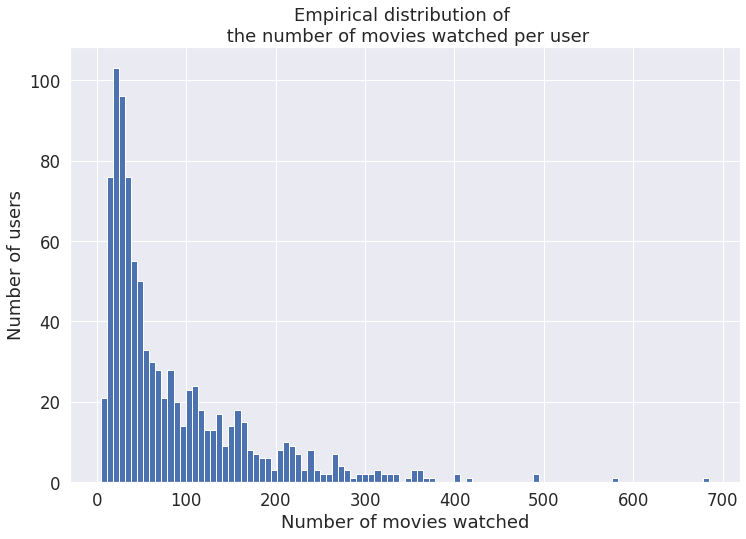

In [ ]:
sns.set(rc={'figure.figsize': (12,8)})
sns.set(font_scale = 1.5)

plt.title('Empirical distribution of \n the number of movies watched per user')
plt.xlabel('Number of movies watched')
plt.ylabel('Number of users')
plt.hist(num_movies_watched, 100);

#### Percentage of users having seen a movie

In [ ]:
movie_popularity = np.mean(binarized_train_matrix, axis=0)  # averaging across users(rows)
pd.DataFrame(movie_popularity).describe().T

,count,mean,std,min,25%,50%,75%,max
0,1682.0,0.050437,0.068667,0.0,0.005302,0.022269,0.066808,0.513256


i.e. 50% of movies were seen by less than 2% of users, whereas there are movies that were seen by either no user or by 51% of all users.
 
We can also plot this as a histogram and see how many movies were seen by what proportion of the population.

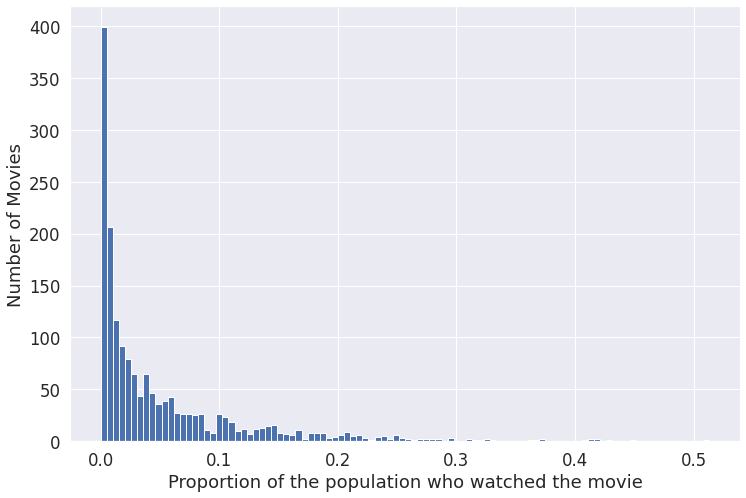

In [ ]:
plt.xlabel('Proportion of the population who watched the movie')
plt.ylabel('Number of Movies')
plt.hist(movie_popularity, 100);

This histogram tells us that a very small fraction of users have seen a large percentage of movies, whereas majority of users have only seen a few movies.

## Construction of the training and validation sets

In [ ]:
def split(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] > 0:
                if np.random.binomial(1, ratio, 1):
                    train[i][j] = data[i][j]
                else:
                    valid[i][j] = data[i][j]

    return (train, valid)

train = split(train_set, 0.8)
test = test_set

# Matrix Factorization

### **Learning loop**

In [ ]:
def learn_to_recommend(data, num_features=10, lr=0.0002, epochs=100, lambdaa=0.02, stopping=0.001):
    """
    Args:
       data: every evaluation
       num_features: number of latent factors/features
       lr: learning rate for gradient descent
       epochs: number of iterations or maximum loops to perform
       lambdaa: L2 regularization to predict ratings different from 0
       stopping: scalar associated with the stopping criterion
      
     Returns:
       P: latent matrix of users / user-factor matrix
       Q: latent matrix of items / item-factor matrix
       loss_train: vector of the different values of the loss function after each iteration on the train
       loss_valid: vector of the different values of the loss function after each iteration not on valid
       """
     
    train, valid = data[0], data[1]
    num_users, num_items = len(train), len(train[0])

    # Initialization of lists
    loss_train, loss_valid = [], []

    P = np.random.rand(num_users, num_features) * 0.1
    Q = np.random.rand(num_items, num_features) * 0.1
    
    for e in range(epochs):        
        for u in range(num_users):
            for i in range(num_items):

                # Considering observed ratings only
                if train[u][i] > 0:
                    error_ui = train[u][i] - prediction(P, Q, u, i)
                    P, Q = sgd(error_ui, P, Q, u, i, num_features, lr, lambdaa)
                               
        # train. and valid. losses after each epoch
        loss_train.append(loss(train, P, Q))
        loss_valid.append(loss(valid, P, Q))
        
        if e % 10 == 0:
            print('Epoch : ', "{:3.0f}".format(e+1), ' | Train :', "{:3.3f}".format(loss_train[-1]), 
                  ' | Valid :', "{:3.3f}".format(loss_valid[-1]))


            
        # Stopping criterion
        if e > 1:
            if abs(loss_valid[-1] - loss_valid[-2]) < stopping:
                break
        
    return P, Q, loss_train, loss_valid

###  **Loss function**

In [ ]:
# predict the evaluation of user u for the movie i
def prediction(P, Q, u, i):
    """
    Args:
        P: user matrix
        Q: matrix of items
        u: index associated with user u
        i: index associated with item i
    Returns:
        pred: the predicted evaluation of the user u for the item i
    """
    
    return np.dot(P[u,:], Q[i,:])

# loss function
def loss(data, P, Q):
    """
    Args:
       data: ratings
       P: matrix of users
       Q: matrix of items   
    Returns:
        MSE: observed mean of squared errors 
    """
    errors_sum, num_evaluations = 0., 0
    num_users, num_items = len(data), len(data[0])

    for u in range(num_users):
        for i in range(num_items):
        
            # Computing error over observed ratings only
            if data[u][i] > 0:
                errors_sum += pow(data[u][i] - prediction(P, Q, u, i), 2)
                num_evaluations += 1
                
    return errors_sum / num_evaluations

### **Estimation**

Parameters' estimates are directly associated with the loss function we are trying to minimize.

#### Stochastic Gradient descent

The function we are trying to minimize is:
 
$$
\begin{align}
\underset{p, q}{\operatorname{min}} L(\mathbf{R}, \lambda) = \underset{p, q}{\operatorname{min}} \sum_{r_{ui} \neq 0} \{(r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda \cdot (||p_u||^2 + ||q_i||^2)\},
\end{align}
$$

we calculate the gradients of the previous equation as a function of $p_u$ and $q_i$:
 
$$
\nabla_{p_{u}} L(\mathbf{R}, \lambda) =  -2q_{i} \cdot \epsilon_{ui} + 2\lambda \cdot p_{u} \quad \text{and} \quad
\nabla_{q_{i}} L(\mathbf{R}, \lambda) =  -2p_{u} \cdot \epsilon_{ui} + 2\lambda \cdot q_{i},
$$
 
where we denote the error by:
 
$$
\epsilon_{ui} = r_{ui} - \hat{r}_{ui}.
$$
 
Finally, for each iteration, as long as the user-item rating is non-zero, we perform the following update on the latent vectors as follows:
 
$$
p_{u}^{(t+1)} \leftarrow p_{u}^{(t)} + \alpha \cdot (2q_{i}^{(t)} \cdot \epsilon_{ui} - 2 \lambda \cdot p_{u}^{(t)}) \\
q_{i}^{(t+1)} \leftarrow q_{i}^{(t)} + \alpha \cdot (2p_{u}^{(t)} \cdot \epsilon_{ui} - 2 \lambda \cdot q_{i}^{(t)}),
$$
 
where $ p_{u}^{(t + 1)}$ is the value of $ p_{u}$ after the $t + 1$ iteration and where $\alpha$ is the learning rate of the descent. That is, we take a step in the opposite direction of the gradients such that we minimize the loss function.

In [ ]:
def sgd(error, P, Q, id_user, id_item, num_features, lr, lambdaa):
    """
    Args:
        error: difference between observed and predicted evaluation (in that order)
        P: matrix of users
        Q: matrix of items
        id_user: id_user
        id_item: id_item
        num_features: number of latent variables
        lr: learning for the descent of the gradient
        lambdaa: scalar multiplier controlling the influence of the regularization term
       
     Returns:
        P: the new estimate for P
        Q: the new estimate for Q
     """    
    
    
    # update  model parameters  P  and  Q
    P[id_user, :] = P[id_user, :] + lr * (2 * Q[id_item, :] * error - 2 * lambdaa * P[id_user, :])
    Q[id_item, :] = Q[id_item, :] + lr * (2 * P[id_user, :] * error - 2 * lambdaa * Q[id_item, :])
      
    return P, Q


### **Training**

In [ ]:
num_features = 5
lr = 0.01
epochs = 101
lambdaa = 0.02
stopping = 0.001

P, Q, loss_train, loss_valid = learn_to_recommend(train, num_features, lr, epochs, lambdaa, stopping)

Epoch :    1  | Train : 7.058  | Valid : 7.052
Epoch :   11  | Train : 0.809  | Valid : 0.991


Once the model is trained, we can visualize the different learning curves.

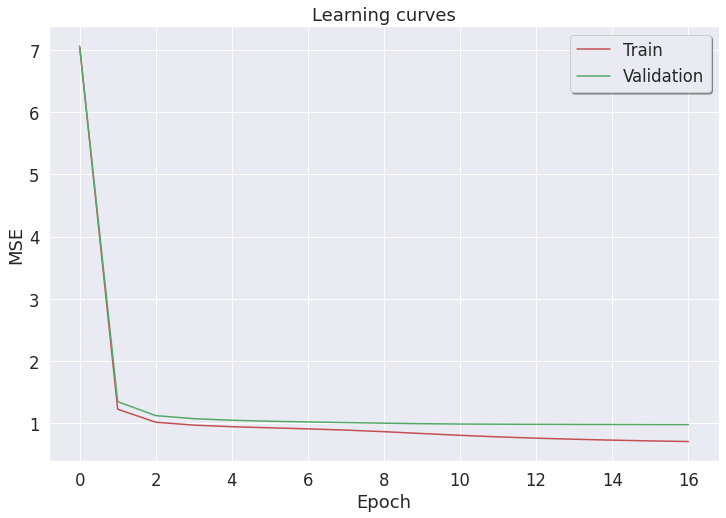

In [ ]:
x = list(range(len(loss_train)))
k=0

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.plot(x[-k:], loss_train[-k:], 'r', label="Train")
plt.plot(x[-k:], loss_valid[-k:], 'g', label="Validation")
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
leg = plt.legend(loc='best', shadow=True, fancybox=True)

### Test set Loss
 Evaluating our model's final performance

In [ ]:
loss(test, P, Q)

0.9890661604258375

##Exploring latent layers

It is possible to explore the various latent variables/factors associated with users and items. By the nature of the matrices $\mathbf{P}$ and $\mathbf{Q}$, we can explore the <i>k</i> latent variables/factors by looking at the columns of $\mathbf{P}$ and $\mathbf{Q}$.

In [ ]:
def explore(movie_titles, item_factor_matrix, frequency_mask, factor_idx, k):
    """
    Args:
       movie_titles: Pandas Series containing movie titles
        item_factor_matrix: matrix containing the model parameters for movies 
        frequency_mask: boolean array masking non-frequent movies
        factor_idx: index of the latent variable
        k: number of movies to show

    Returns:
        names: movie titles
        scores: associated score of movies on a particular factor
    """

    # slice the column to obtain latent variable, then apply mask
    latent_variable = item_factor_matrix[:, factor_idx] * frequency_mask

    # filter out infrequent movies
    nonzero_indices = np.nonzero(latent_variable)
    movies = np.array(movie_titles)[nonzero_indices][:k]
    latent_variable = latent_variable[nonzero_indices][:k]

    return movies, latent_variable


Let's now go ahead and use this function to visualize the results. We will do this while only considering movies that have been watched by at least 10% of all users. To do this, let's use the movie_popularity list we created earlier.

In [ ]:
print(movie_popularity)
print(movie_popularity.shape)

[0.40615058 0.11134677 0.0795334  ... 0.00106045 0.00106045 0.00106045]
(1682,)


In [ ]:
k = 5
factor_idx = 0
threshold = 0.1         # considering movies watched by at least 10% of all users
names, scores = explore(movies['Title'], Q, np.where(movie_popularity > threshold, 1, 0), factor_idx, k)

df = pd.DataFrame(np.matrix((names, scores)).T, (np.arange(len(scores)) + 1).tolist())
df.columns = ['Title', 'Latent factor']
df

,Title,Latent factor
1,Toy Story (1995),1.550587
2,GoldenEye (1995),0.371499
3,Get Shorty (1995),0.642945
4,Twelve Monkeys (1995),1.588772
5,Babe (1995),1.627767


# Applications
We can now put our model to use and generate personalized recommendations for users.

We will choose a given user, and consider his/her preferences. Then we will generate recommendations for him/her using our trained matrix factorization model with the caveat in mind that we only want to recommend movies that he/she has not seen in the past.
 

In [ ]:
def rank_top_k(movie_names, ratings, k=10):
   """
   Args:
        movie_names: names of all movies in our dataset
        ratings: estimated ratings on movies not seen by a user

   Returns:
        top k recommended movies and corresponding estimated scores by the user
        
   Example:
   a, b = np.array(['a', 'b', 'c']), np.array([6, 1, 3])
   a, b = rank_top_k(a, b, k=2)
   >>> a
   np.array('a', 'c')
   >>> b
   np.array([6, 3])
   """
 
   # rank indices in descending order
   ranked_ids = np.argsort(ratings)[::-1]
 
   return movie_names[ranked_ids][:k], ratings[ranked_ids][:k]

In [ ]:
user_id = 14
top_k = 10

# Step 1: Define the user's preferences using the training set.
user_train = np.array(train[0][user_id])


# Step 2: Define what movies the user has not seen yet.
# We will only generate recommendations for these movies, so make sure we store this in an awway equal to the number of all movies.
movies_not_seen = np.where(user_train == 0, 1, 0)

# Step 3: Predict the user's ratings across all movies.
estimates = np.dot(P[user_id, :], Q.T)


# Step 4: Consider the estimated ratings for movies that were not seen by the user.
unseen_movie_estimates = estimates * movies_not_seen

# Step 5: Retrieve the top k recommendations for that user.
recommendations, scores = rank_top_k(np.array(movies['Title']), unseen_movie_estimates, k=top_k)


# Step 6: Show the title and associated latent feature of the recommendations
df = pd.DataFrame(np.matrix((recommendations, scores)).T, (np.arange(10) + 1).tolist(), 
                  columns=['Title', 'Predicted rating'])
df


,Title,Predicted rating
1,Pather Panchali (1955),4.094992
2,To Kill a Mockingbird (1962),4.037752
3,Schindler's List (1993),3.929409
4,E.T. the Extra-Terrestrial (1982),3.896012
5,Good Will Hunting (1997),3.854905
6,Fargo (1996),3.807921
7,Love in the Afternoon (1957),3.780029
8,Fried Green Tomatoes (1991),3.764348
9,"Wizard of Oz, The (1939)",3.762431
10,"Wrong Trousers, The (1993)",3.756625
